In [16]:
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt

In [ ]:
import cv2 as cv

## Basic Operations
https://docs.opencv.org/4.x/d3/df2/tutorial_py_basic_ops.html

### Loading an image

In [9]:
img_path = "../leaf-image-sequences/raw/2023/20230525/20230525_172420_ESWW0070020_1.JPG"
img = cv.imread(img_path) # loads image

if img is None:
    sys.exit("Could not read the image.")
else:
    print("Image read successfully.")

# cv.imwrite("test.png", img) # save image


# requires opencv GUI
# cv.imshow("Display window", img) # display image
# k = cv.waitKey(0) # wait until a key is pressed
 
# if k == ord("s"): # check if pressed key is 's'
#     cv.imwrite("test.png", img) # save image


Image read successfully.


### Accessing and Modifying Pixel Values

In [10]:
px = img[100,100] # retrieves the BRG (Blue, Red, Green) values of that pixel

blue = img[100,100,0] # accessing only blue pixel


img[100,100] = [255,255,255] # modify pixel values

### Accessing Image Properties

In [14]:
img.size # returns total number of pixels
img.shape # returns image shape, e.g. (256, 256, 3)

(5464, 8192, 3)

### Regions of Interest
(just indexing with numpy)

In [12]:
slice = img[280:340, 330:390] # slice with numpy to select a ROI
img[273:333, 100:160] = slice # can copy the ROI to another area

### Splitting & Merging channels

In [13]:
b,g,r = cv.split(img) # splits image into individual channels -> very costly
b = img[:,:,0] # same, just with indexing
img = cv.merge((b,g,r)) # merge channels into a complete image again

### Borders

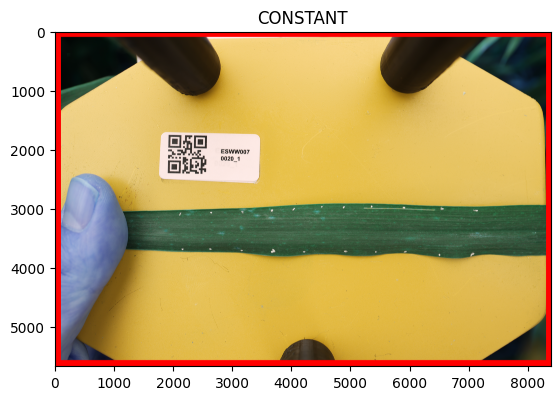

In [18]:
col = [255, 0, 0]
constant = cv.copyMakeBorder(img,100,100,100,100,cv.BORDER_CONSTANT,value=col) # numbers are size of border. different border modes exist

plt.subplot(111),plt.imshow(constant,'gray'),plt.title('CONSTANT')
 
plt.show()

## Arithmetic Operations on Images

https://docs.opencv.org/4.x/d0/d86/tutorial_py_image_arithmetics.html

### Addition
- Can add images with `cv.add(img1, img2)` (saturated) or `img1 + img2` (modulo)  
- images should have the same depth and type, or the second image can just be a scalar value.
- can do weighted addition $\alpha*I_1 + \beta*I_2 + \gamma$ with `cv.addWeighted(img1, alpha,img2, beta, gamma)`

### Bitwise Operations
- AND, OR, NOT, XOR
- highly useful while extracting any part of the image

E.g. can superimpose img2 over another img1:
- create ROI of img1 where you want put img2
- create mask of img2 and create its inverse mask 
```
img2gray = cv.cvtColor(img2,cv.COLOR_BGR2GRAY) # make image gray
ret, mask = cv.threshold(img2gray, 10, 255, cv.THRESH_BINARY) # threshold to make mask
mask_inv = cv.bitwise_not(mask) # invert mask 
```
- black-out the area of img2 in ROI of img1
`img1_bg = cv.bitwise_and(roi,roi,mask = mask_inv)`
- Take only region of logo from logo image (img2).
`img2_fg = cv.bitwise_and(img2,img2,mask = mask)`
- Put logo in ROI of img1 and modify the main image (img1)
```
dst = cv.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst
```

## Performance Measurement and Improvement Techniques
https://docs.opencv.org/4.x/dc/d71/tutorial_py_optimization.html

- `cv.getTickCount()` -> like `time.time` but in ticks -> divide by `cv.getTickFrequency` to get seconds
- `cv.useOptimized()` to check if optimized code is enabled/disabled and `cv.setUseOptimized()` to enable/disable it
- Normally, OpenCV functions are faster than Numpy functions. So for same operation, OpenCV functions are preferred. But, there can be exceptions, especially when Numpy works with views instead of copies.

## Track Object via Color

In [ ]:
# Convert BGR to HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# define range of blue color you want to track in HSV
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# to find HSV values:
green = np.uint8([[[0,255,0 ]]]) # color val in RGB
hsv_green = cv.cvtColor(green,cv.COLOR_BGR2HSV) # convert to HSV

# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv.bitwise_and(img, img, mask= mask)

plt.subplot(311),plt.imshow(img,'gray'),plt.title('Original')
plt.subplot(312),plt.imshow(mask,'gray'),plt.title('Mask')
plt.subplot(313),plt.imshow(res,'gray'),plt.title('Result')
 
plt.show()

## Transformations
https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html 

- Scaling/resizing: `cv.resize` -> can specify interpolation method. sizes either by absolute values or factors
- Translation: `cv.warpAffine(image, Matrix, (output_width, output_height))`
- Rotation: `cv.warpAffine(img, Matrix, (output_width, output_height))` -> use `cv.getRotationMatrix2D` to find transformation Matrix
- Affine: `cv.warpAffine` -> use `cv.getAffineTransform` to find transformation Matrix -> tell it coords of 3 points before and after
- Perspective: `cv.warpPerspective` -> use `cv.getPerspectiveTransform` to find transformation Matrix -> tell it coords of 4 points before and after

## Thresholding
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

### Global Thresholding
`cv.threshold` -> takes **grey-scale** images as input -> specify threshold value + thresholding method, i.e. how to extend values 

### Adaptive Thresholding
TLDR: determine threshold for a pixel based on small region around it (useful for varying illumination)  
`cv.adaptiveThreshold` -> can choose method for determining threshold value, as wel as size of neighborhood

### Otsu's Binarization
TLDR: global thresholding, but you don't have to choose threshold value yourself  
`cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)` -> pass OTSU as extra flag

## Smoothing
https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

- convolutional filters: `cv.filter2D` -> supply kernel matrix
- blurring: `cv.blur`/`cv.boxFilter` (mean filter), `cv.GaussianBlur`, `cv.medianBlur`, `cv.bilateralFilter`(preserves edges)